In [1]:
#Importando bibliotecas necessárias
import numpy as np
import pandas as pd
import sklearn     
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from imblearn.over_sampling import SMOTE 
import pkg_resources


In [2]:
# Diretório com os 4 dataset do INMET agrupados em um unico dataset
diretorio = './Dados/INMET/Unificados/dataset_INMET-Salvador.csv'
diretorio_api = './Dados/API/dados_api_ate_2022.csv'

In [3]:
# Leitura do dataset
dados = pd.read_csv(diretorio) 
dados_api = pd.read_csv(diretorio_api)

In [4]:
# Retirando uma amostra do dataset
dados = dados.sample(1461)

## Classificação com dados INMET e Meteo Open

In [5]:
#Sintonizando hiperparâmetros para o  modelo usando validação cruzada
def tuner(clf, dist, X, y):
  rs_clf = RandomizedSearchCV(estimator=clf, random_state=1, n_jobs=-1, param_distributions=dist, cv=10)

  search = rs_clf.fit(X=X, y=y)

  return search.best_params_

In [6]:
#Função para gerar e exibir uma matriz de confusão para avaliar o desempenho do modelo
def plot_confusion_matrix(y_true, y_pred, labels):
  cm = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=labels)

  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

  disp.plot(cmap=plt.cm.Blues)

  plt.show()

In [7]:
#Função para gerar relatório para avaliação
def reporter(clf, X, y, labels):

  predictions = clf.predict(X)

  plot_confusion_matrix(y_true=y, y_pred=predictions, labels=labels)

  print(classification_report(y_true=y, y_pred=predictions))
    


In [8]:
# Transformando dados numericos da coluna precipitação em labels de acordo com intervalos
def categorize_precipitation(value):
    if value == 0:
        return 'Não choveu'
    elif 0 < value <= 10:
        return 'Choveu pouco'
    elif 10 < value <= 30:
        return 'Choveu moderado'
    elif 30 < value <= 100:
        return 'Chuva intensa'
    else:
        return 'Valor fora dos intervalos especificados'

dados['CATEGORIA_PRECIPITACAO'] = dados['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'].apply(categorize_precipitation)


print(dados['CATEGORIA_PRECIPITACAO'].value_counts())

print(dados.head())


Não choveu         1315
Choveu pouco        144
Choveu moderado       2
Name: CATEGORIA_PRECIPITACAO, dtype: int64
     DATA (YYYY-MM-DD)  Hora UTC  PRECIPITAÇÃO TOTAL, HORÁRIO (mm)  \
6509        2023-09-29  0500 UTC                               0.0   
2379        2023-04-10  0300 UTC                               0.0   
5531        2023-08-19  1100 UTC                               0.0   
7270        2023-10-30  2200 UTC                               0.0   
4535        2023-07-08  2300 UTC                               0.0   

      PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)  \
6509                                             1007.1       
2379                                             1007.6       
5531                                             1009.9       
7270                                             1005.8       
4535                                             1011.1       

      RADIACAO GLOBAL (KJ/m²)  TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)  \
6509  

In [27]:
contagem_categorias = dados['CATEGORIA_PRECIPITACAO'].value_counts() 
contagem_categorias

Não choveu         1315
Choveu pouco        144
Choveu moderado       2
Name: CATEGORIA_PRECIPITACAO, dtype: int64

In [29]:
# Transformando dados numericos da coluna precipitação em labels de acordo com intervalos
def categorize_precipitation(value):
    if value == 0:
        return 'Não choveu'
    elif 0 < value <= 10:
        return 'Choveu pouco'
    elif 10 < value <= 30:
        return 'Choveu moderado'
    elif 30 < value <= 100:
        return 'Chuva intensa'
    else:
        return 'Valor fora dos intervalos especificados'

dados_api['CATEGORIA_PRECIPITACAO'] = dados_api['precipitation_sum'].apply(categorize_precipitation)


print(dados_api['precipitation_sum'].value_counts())

print(dados_api.head())

13.768294    1
10.995005    1
14.862082    1
16.792984    1
16.462568    1
            ..
7.676537     1
10.338423    1
13.329301    1
8.990122     1
13.155447    1
Name: precipitation_sum, Length: 1461, dtype: int64
         date  temperature_2m_mean  temperature_2m_max  temperature_2m_min  \
0  2019-01-01            26.815092           25.020996           85.708015   
1  2019-01-02            28.864230           24.866518           82.718410   
2  2019-01-03            27.511778           23.711008           84.713490   
3  2019-01-04            28.759325           24.105497           82.708580   
4  2019-01-05            29.206875           24.749987           81.703670   

   wind_speed_10m_mean  wind_speed_10m_max  cloud_cover_mean  \
0            91.317510            77.23299          2.134795   
1            92.345540            65.24041          4.727908   
2            91.363510            80.23677          2.239490   
3            92.381480            68.23312          0.4701

In [30]:
contagem_categorias = dados_api['CATEGORIA_PRECIPITACAO'].value_counts() 
contagem_categorias

Choveu moderado    1281
Choveu pouco        180
Name: CATEGORIA_PRECIPITACAO, dtype: int64

In [9]:
# Selecionar características relevantes
features = dados_api[[ 'temperature_2m_mean', 'relative_humidity_2m_max', 'wind_speed_10m_mean']]
#Define a variavel a ser prevista
targets = dados['CATEGORIA_PRECIPITACAO']

In [11]:
X_train, X_test_valid, y_train, y_test_valid = train_test_split(features, targets,test_size=0.3)

In [12]:
X_test, X_valid, y_test, y_valid = train_test_split(X_test_valid, y_test_valid,test_size=0.7) 


In [13]:
max_depths = [i for i in range(1, 30, 2)]

In [14]:
scaler = MinMaxScaler()

X_train_normalized = scaler.fit_transform(X_train)
X_valid_normalized = scaler.transform(X_valid)
X_test_normalized = scaler.transform(X_test)
     


E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Melhores parâmetros: {'n_neighbors': 55}
Train


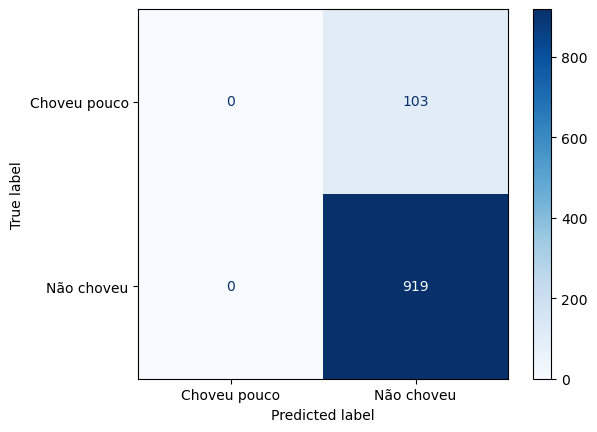

E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

Choveu pouco       0.00      0.00      0.00       103
  Não choveu       0.90      1.00      0.95       919

    accuracy                           0.90      1022
   macro avg       0.45      0.50      0.47      1022
weighted avg       0.81      0.90      0.85      1022

Cross Validation


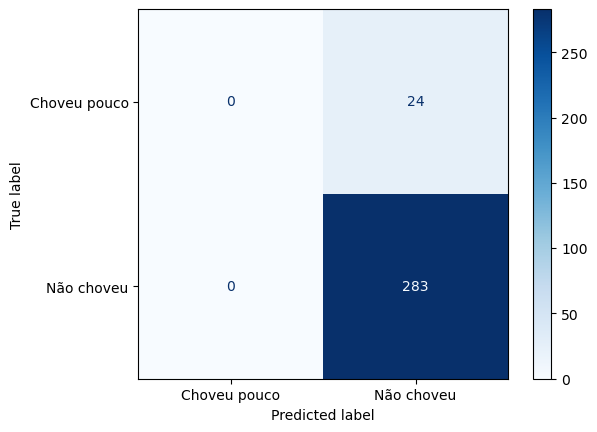

E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                 precision    recall  f1-score   support

Choveu moderado       0.00      0.00      0.00         1
   Choveu pouco       0.00      0.00      0.00        24
     Não choveu       0.92      1.00      0.96       283

       accuracy                           0.92       308
      macro avg       0.31      0.33      0.32       308
   weighted avg       0.84      0.92      0.88       308

Test


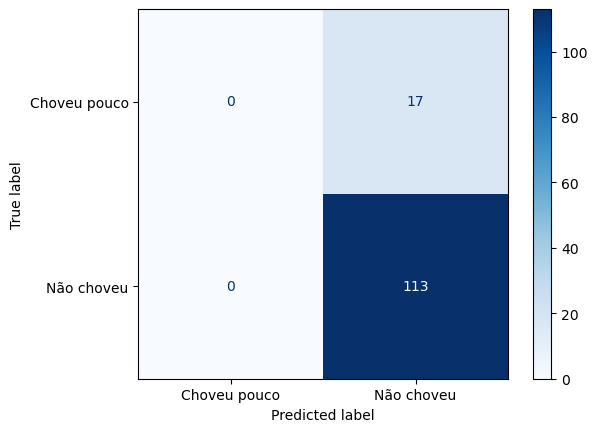

                 precision    recall  f1-score   support

Choveu moderado       0.00      0.00      0.00         1
   Choveu pouco       0.00      0.00      0.00        17
     Não choveu       0.86      1.00      0.93       113

       accuracy                           0.86       131
      macro avg       0.29      0.33      0.31       131
   weighted avg       0.74      0.86      0.80       131



E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
dist = dict(n_neighbors=[i for i in range(1, 100, 2)]) 
n_samples = X_test.shape[0]
knc = KNeighborsClassifier(n_jobs=-1)

best = tuner(knc, dist, X_valid_normalized, y_valid)

print(f'Melhores parâmetros: {best}')

knc = KNeighborsClassifier(n_jobs=-1, n_neighbors=best['n_neighbors'])

knc.fit(X_train_normalized, y_train)

labels = np.unique(y_train)

print('Train')
reporter(knc, X_train_normalized, y_train, labels)

print('Cross Validation')
reporter(knc, X_valid_normalized, y_valid, labels)

print('Test')
reporter(knc, X_test_normalized, y_test, labels)


In [16]:
dist = dict(max_depth=max_depths)

dtc = DecisionTreeClassifier(random_state=1)

best = tuner(dtc, dist, X_valid, y_valid)

print(f'Melhores parâmetros: {best}')

dtc = DecisionTreeClassifier(random_state=1, max_depth=best['max_depth'])
result = dtc.fit(X_train, y_train)

E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Melhores parâmetros: {'max_depth': 1}


In [25]:
# Aplicando SMOTE para balancear as classes
smote = SMOTE(sampling_strategy='auto', k_neighbors=3, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


# Treinando um modelo (por exemplo, RandomForest)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

# Fazendo previsões
y_pred = clf.predict(X_test)

# Avaliando o desempenho
print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

Choveu moderado       0.00      0.00      0.00         1
   Choveu pouco       0.13      0.35      0.19        17
     Não choveu       0.87      0.65      0.75       113

       accuracy                           0.61       131
      macro avg       0.33      0.34      0.31       131
   weighted avg       0.77      0.61      0.67       131



E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Melhores parâmetros: {'max_depth': 1}
Train


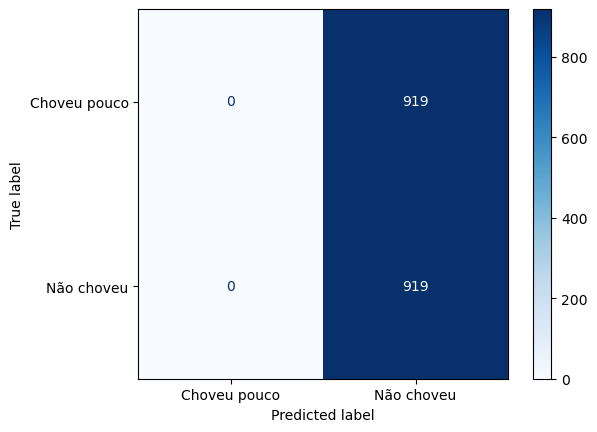

              precision    recall  f1-score   support

Choveu pouco       0.00      0.00      0.00       919
  Não choveu       0.50      1.00      0.67       919

    accuracy                           0.50      1838
   macro avg       0.25      0.50      0.33      1838
weighted avg       0.25      0.50      0.33      1838

Cross Validation


E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


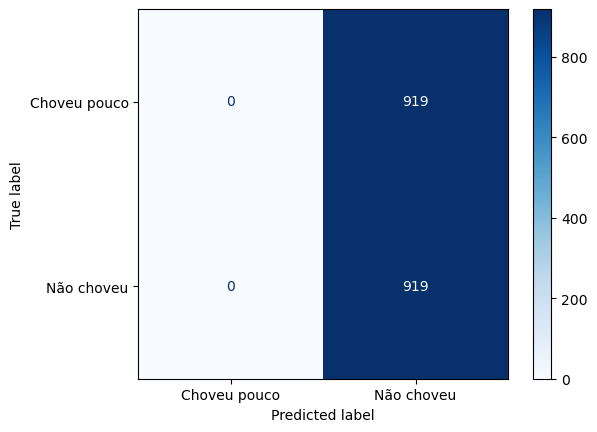

E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

Choveu pouco       0.00      0.00      0.00       919
  Não choveu       0.50      1.00      0.67       919

    accuracy                           0.50      1838
   macro avg       0.25      0.50      0.33      1838
weighted avg       0.25      0.50      0.33      1838

Test


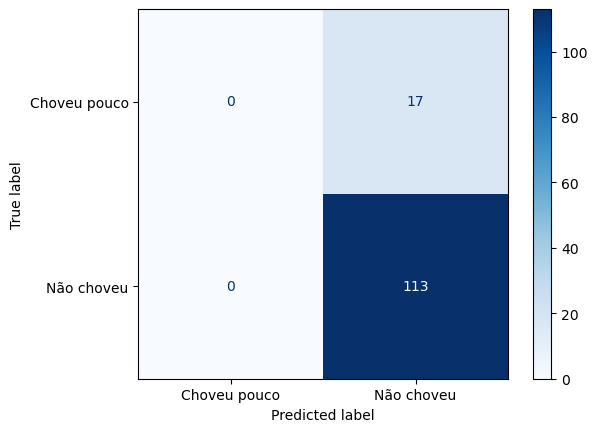

                 precision    recall  f1-score   support

Choveu moderado       0.00      0.00      0.00         1
   Choveu pouco       0.00      0.00      0.00        17
     Não choveu       0.86      1.00      0.93       113

       accuracy                           0.86       131
      macro avg       0.29      0.33      0.31       131
   weighted avg       0.74      0.86      0.80       131



E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:

dist = dict(max_depth=max_depths)

rfc = RandomForestClassifier(n_jobs=-1, random_state=1)

best = tuner(rfc, dist, X_valid, y_valid)

print(f'Melhores parâmetros: {best}')

rfc = RandomForestClassifier(n_jobs=-1, random_state=1, max_depth=best['max_depth'])

rfc.fit(X_train, y_train)

print('Train')
reporter(rfc, X_train_resampled, y_train_resampled, labels)
print('Cross Validation')
reporter(rfc, X_train_resampled, y_train_resampled, labels)
print('Test')
reporter(rfc, X_test, y_test, labels)

In [32]:
# Selecionar características relevantes
features = dados[[ 'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)', 'UMIDADE RELATIVA DO AR, HORARIA (%)', 'VENTO, VELOCIDADE HORARIA (m/s)']]
#Define a variavel a ser prevista
targets = dados_api['CATEGORIA_PRECIPITACAO']

In [33]:
X_train, X_test_valid, y_train, y_test_valid = train_test_split(features, targets,test_size=0.3)

In [34]:
X_test, X_valid, y_test, y_valid = train_test_split(X_test_valid, y_test_valid,test_size=0.7) 


In [35]:
max_depths = [i for i in range(1, 30, 2)]

In [36]:
scaler = MinMaxScaler()

X_train_normalized = scaler.fit_transform(X_train)
X_valid_normalized = scaler.transform(X_valid)
X_test_normalized = scaler.transform(X_test)
     

Melhores parâmetros: {'n_neighbors': 55}
Train


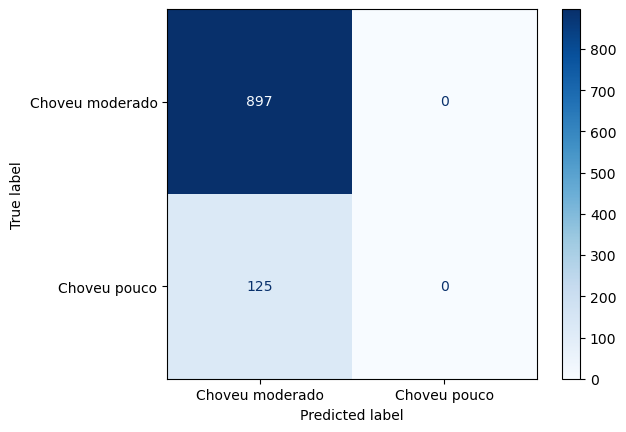

                 precision    recall  f1-score   support

Choveu moderado       0.88      1.00      0.93       897
   Choveu pouco       0.00      0.00      0.00       125

       accuracy                           0.88      1022
      macro avg       0.44      0.50      0.47      1022
   weighted avg       0.77      0.88      0.82      1022

Cross Validation


E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


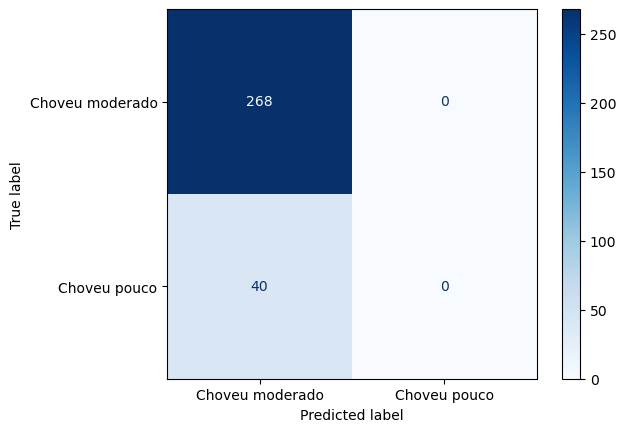

E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                 precision    recall  f1-score   support

Choveu moderado       0.87      1.00      0.93       268
   Choveu pouco       0.00      0.00      0.00        40

       accuracy                           0.87       308
      macro avg       0.44      0.50      0.47       308
   weighted avg       0.76      0.87      0.81       308

Test


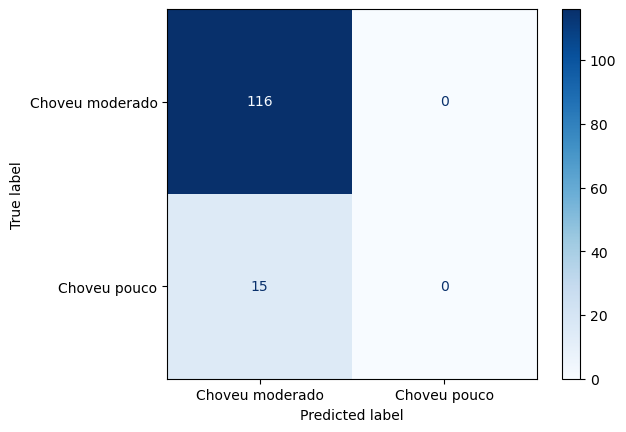

                 precision    recall  f1-score   support

Choveu moderado       0.89      1.00      0.94       116
   Choveu pouco       0.00      0.00      0.00        15

       accuracy                           0.89       131
      macro avg       0.44      0.50      0.47       131
   weighted avg       0.78      0.89      0.83       131



E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
dist = dict(n_neighbors=[i for i in range(1, 100, 2)]) 
n_samples = X_test.shape[0]
knc = KNeighborsClassifier(n_jobs=-1)

best = tuner(knc, dist, X_valid_normalized, y_valid)

print(f'Melhores parâmetros: {best}')

knc = KNeighborsClassifier(n_jobs=-1, n_neighbors=best['n_neighbors'])

knc.fit(X_train_normalized, y_train)

labels = np.unique(y_train)

print('Train')
reporter(knc, X_train_normalized, y_train, labels)

print('Cross Validation')
reporter(knc, X_valid_normalized, y_valid, labels)

print('Test')
reporter(knc, X_test_normalized, y_test, labels)